<a href="https://colab.research.google.com/github/tortoisehare/TSR-GAN/blob/master/fullGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir weights
!mkdir weights/target_model
!mkdir weights/generator
!mkdir weights/discriminator
!ls

mkdir: cannot create directory ‘weights’: File exists
mkdir: cannot create directory ‘weights/target_model’: File exists
mkdir: cannot create directory ‘weights/generator’: File exists
mkdir: cannot create directory ‘weights/discriminator’: File exists
sample_data  test.p  train.p  valid.p  weights


1.13.1


Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Training ...

Epoch:  0001 cost= 1.202183108
EPOCH 1 : Validation Accuracy = 83.016%
Epoch:  0002 cost= 0.278367689
EPOCH 2 : Validation Accuracy = 89.002%
Epoch:  0003 cost= 0.153129038
EPOCH 3 : Validation Accuracy = 89.955%
Epoch:  0004 cost= 0.106524747
EPOCH 4 : Validation Accuracy = 90.023%
Epoch:  0005 cost= 0.074324498
EPOCH 5 : Validation Accuracy = 89.637%
Test Accuracy = 88.0%


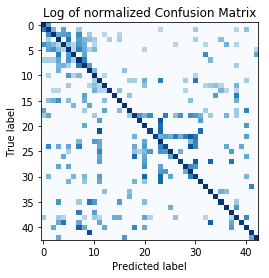

Model saved


In [2]:
#TARGET CLASSIFIER

import numpy as np
np.random.seed(1187) #to help reproduce

#from __future__ import print_function
import tensorflow as tf
print(tf.__version__)

import matplotlib.pyplot as plt
import os
import csv
#import random
#import cv2
#from skimage.filters import rank
#import skimage.morphology as morp
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle

#from keras.utils import to_categorical
#from keras.models import Sequential
from keras.layers import Flatten
#from keras.layers import Convolution2D, MaxPooling2D
from keras import optimizers



class Target:
    def __init__(self, lr=0.001, epochs=5, n_input=32, n_classes=43, batch_size=20, restore=0):
        self.lr = lr
        self.epochs = epochs
        self.n_input = 32
        self.n_classes = 43
        self.batch_size = batch_size
        self.restore = restore

        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    
    '''
    def next_batch(self, X, Y, i, batch_size):
      idx = i*batch_size
      idx_n = idx + batch_size
      return X[idx:idx_n], Y[idx:idx_n]
      '''
    
    def Model(self, x):
        with tf.variable_scope('Model', reuse=tf.AUTO_REUSE):
            # Hyperparameters
            mu = 0
            sigma = 0.1
            n_out = self.n_classes
            learning_rate = self.lr

            # Layer 1 (Convolutional): Input = 32x32x1. Output = 28x28x6.
            filter1_width = 5
            filter1_height = 5
            input1_channels = 1
            conv1_output = 6
            # Weight and bias
            conv1_weight = tf.Variable(tf.truncated_normal(
                shape=(filter1_width, filter1_height, input1_channels, conv1_output),
                mean = mu, stddev = sigma))
            conv1_bias = tf.Variable(tf.zeros(conv1_output))

            # Apply Convolution
            conv1 = tf.nn.conv2d(x, conv1_weight, strides=[1, 1, 1, 1], padding='VALID') + conv1_bias

            # Activation:
            conv1 = tf.nn.relu(conv1)

            # Pooling: Input = 28x28x6. Output = 14x14x6.
            conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

            # Layer 2 (Convolutional): Output = 10x10x16.
            filter2_width = 5
            filter2_height = 5
            input2_channels = 6
            conv2_output = 16
            # Weight and bias
            conv2_weight = tf.Variable(tf.truncated_normal(
                shape=(filter2_width, filter2_height, input2_channels, conv2_output),
                mean = mu, stddev = sigma))
            conv2_bias = tf.Variable(tf.zeros(conv2_output))

            # Apply Convolution
            conv2 = tf.nn.conv2d(conv1, conv2_weight, strides=[1, 1, 1, 1], padding='VALID') + conv2_bias

            # Activation:
            conv2 = tf.nn.relu(conv2)

            # Pooling: Input = 10x10x16. Output = 5x5x16.
            conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

            # Flattening: Input = 5x5x16. Output = 400.
            fully_connected0 = Flatten()(conv2)

            # Layer 3 (Fully Connected): Input = 400. Output = 120.
            connected1_weights = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
            connected1_bias = tf.Variable(tf.zeros(120))
            fully_connected1 = tf.add((tf.matmul(fully_connected0, connected1_weights)), connected1_bias)

            # Activation:
            fully_connected1 = tf.nn.relu(fully_connected1)

            # Layer 4 (Fully Connected): Input = 120. Output = 84.
            connected2_weights = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
            connected2_bias = tf.Variable(tf.zeros(84))
            fully_connected2 = tf.add((tf.matmul(fully_connected1, connected2_weights)), connected2_bias)

            # Activation.
            fully_connected2 = tf.nn.relu(fully_connected2)
    
            # Layer 5 (Fully Connected): Input = 84. Output = 43.
            output_weights = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
            output_bias = tf.Variable(tf.zeros(43))
            logits =  tf.add((tf.matmul(fully_connected2, output_weights)), output_bias)

            probs = tf.nn.sigmoid(logits)
            
            return logits, probs
    
    
    
    def test(self, X_data, BATCH_SIZE=64):
        num_examples = len(X_data)
        y_pred = np.zeros(num_examples, dtype=np.int32)
        sess = tf.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x = X_data[offset:offset+BATCH_SIZE]
            y_pred[offset:offset+BATCH_SIZE] = sess.run(tf.argmax(logits, 1), 
                               feed_dict={x:batch_x, keep_prob:1, keep_prob_conv:1})
        return y_pred
    
    
    def train(self, X_train, Y_train, X_valid, Y_valid):
        #placeholders for inputs
        x = tf.placeholder(tf.float32, (None, 32, 32, 1))
        y = tf.placeholder(tf.int32, (None))

        keep_prob = tf.placeholder(tf.float32)       # For fully-connected layers
        keep_prob_conv = tf.placeholder(tf.float32)

        #define graph
        logits, _ = self.Model(x)
        
              # Training operation
        one_hot_y = tf.one_hot(y, 43)
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=one_hot_y)
        loss_operation = tf.reduce_mean(cross_entropy)
        optimizer = tf.train.AdamOptimizer(learning_rate = self.lr)
        training_operation = optimizer.minimize(loss_operation)

        # Accuracy operation
        correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
        accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


          # Saving all variables
        saver = tf.train.Saver()

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            num_train = len(Y_train)
            num_valid = len(Y_valid)
            print("Training ...")
            print()
            EPOCHS = self.epochs
            BATCH_SIZE = self.batch_size
            DIR = "./weights/target_model"
            total_batch = int(X_train.shape[0] / self.batch_size)

            for i in range(EPOCHS):
                avg_cost = 0.
                total_accuracy = 0
                validation_accuracy = 0
                #Train set
                for offset in range(0, num_train, BATCH_SIZE):
                    end = offset + BATCH_SIZE
                    batch_x, batch_y = X_train[offset:end], Y_train[offset:end]
                    _, c = sess.run([training_operation, loss_operation], feed_dict={x: batch_x, y: batch_y, keep_prob : 0.6, keep_prob_conv: 0.8})
                    avg_cost += c / total_batch
                    
                    #Validation Set
                for offset in range(0, num_valid, BATCH_SIZE):
                    end = offset + BATCH_SIZE
                    batch_x, batch_y = X_valid[offset:end], Y_valid[offset:end]
                    accuracy = sess.run(accuracy_operation, 
                                    feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0, keep_prob_conv: 1.0 })
                    total_accuracy += (accuracy * len(batch_x))
                    validation_accuracy = total_accuracy / num_valid
                    #print("Validation Accuracy = {:.3f}%".format(validation_accuracy*100))
                    
                print("Epoch: ", '%04d' % (i+1), "cost=", "{:.9f}".format(avg_cost))
                print("EPOCH {} : Validation Accuracy = {:.3f}%".format(i+1, (validation_accuracy*100)))
            
            
            #Test set
            num_examples = len(X_test)
            y_pred = np.zeros(num_examples, dtype=np.int32)
            #sess = tf.get_default_session()
            for offset in range(0, num_examples, BATCH_SIZE):
                batch_x = X_test[offset:offset+BATCH_SIZE]
                y_pred[offset:offset+BATCH_SIZE] = sess.run(tf.argmax(logits, 1), 
                                   feed_dict={x:batch_x, keep_prob:1, keep_prob_conv:1})
            test_accuracy = sum(Y_test == y_pred)/len(Y_test)
            print("Test Accuracy = {:.1f}%".format(test_accuracy*100))

            cm = confusion_matrix(Y_test, y_pred)
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            cm = np.log(.0001 + cm)
            plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
            plt.title('Log of normalized Confusion Matrix')
            plt.ylabel('True label')
            plt.xlabel('Predicted label')
            plt.show()
            
            saver.save(sess, "./weights/target_model/model")
            print("Model saved")
            sess.close()

   
      
      
import pickle

if __name__ == '__main__':
    training_file = 'train.p'
    testing_file = 'test.p'
    validation_file = 'valid.p'

    with open(training_file, mode='rb') as f:
        tstrain = pickle.load(f)
    with open(testing_file, mode='rb') as f:
        tstest = pickle.load(f)
    with open(validation_file, mode='rb') as f:
        tsvalid = pickle.load(f)

    X_train, Y_train = tstrain['features'], tstrain['labels']
    X_valid, Y_valid = tsvalid['features'], tsvalid['labels']
    X_test, Y_test = tstest['features'], tstest['labels']

    #shuffle training set
    X_train, Y_train = shuffle(X_train, Y_train)

    #grayscale images
    grayscale = [0.299,0.587,0.144]

    X_test = np.dot(X_test, grayscale)
    X_train = np.dot(X_train, grayscale)
    X_valid = np.dot(X_valid, grayscale)


    #normalize
    X_train = np.array(X_train)/255
    X_test = np.array(X_test)/255
    X_valid = np.array(X_valid)/255

    #expand dimensions to fit 4D input array
    X_train = np.expand_dims(X_train,-1)
    X_test = np.expand_dims(X_test,-1)
    X_valid = np.expand_dims(X_valid,-1)

    assert(len(X_train)==len(Y_train))
    n_train = len(X_train)
    assert(len(X_test)==len(Y_test))
    n_test = len(X_test)

    cnn = Target()
    cnn.train(X_train, Y_train, X_valid, Y_valid)

In [0]:
#Generator
'''
	Generator definition for AdvGAN
	ref: https://arxiv.org/pdf/1801.02610.pdf
'''

import tensorflow as tf

# helper function for convolution -> instance norm -> relu
def ConvInstNormRelu(x, filters, kernel_size=3, strides=1):
	Conv = tf.layers.conv2d(
						inputs=x,
						filters=filters,
						kernel_size=kernel_size,
						strides=strides,
						padding="same",
						activation=None)

	InstNorm = tf.contrib.layers.instance_norm(Conv)

	return tf.nn.relu(InstNorm)


# helper function for trans convolution -> instance norm -> relu
def TransConvInstNormRelu(x, filters, kernel_size=3, strides=2):
	TransConv = tf.layers.conv2d_transpose(
						inputs=x,
						filters=filters,
						kernel_size=kernel_size,
						strides=strides,
						padding="same",
						activation=None)

	InstNorm = tf.contrib.layers.instance_norm(TransConv)

	return tf.nn.relu(InstNorm)

# helper function for residual block of 2 convolutions with same num filters
# in the same style as ConvInstNormRelu
def ResBlock(x, training, filters=32, kernel_size=3, strides=1):
	conv1 = tf.layers.conv2d(
						inputs=x,
						filters=filters,
						kernel_size=kernel_size,
						strides=strides,
						padding="same",
						activation=None)

	conv1_norm = tf.layers.batch_normalization(conv1, training=training)

	conv1_relu = tf.nn.relu(conv1_norm)

	conv2 = tf.layers.conv2d(
						inputs=conv1_relu,
						filters=filters,
						kernel_size=kernel_size,
						strides=strides,
						padding="same",
						activation=None)

	conv2_norm = tf.layers.batch_normalization(conv2, training=training)


	return x + conv2_norm


def generator(x, training):
	with tf.variable_scope('g_weights', reuse=tf.AUTO_REUSE): #True
		# input_layer = tf.reshape(x, [-1, 28, 28, 1])

		# define first three conv + inst + relu layers
		c1 = ConvInstNormRelu(x, filters=8, kernel_size=3, strides=1)
		d1 = ConvInstNormRelu(c1, filters=16, kernel_size=3, strides=2)
		d2 = ConvInstNormRelu(d1, filters=32, kernel_size=3, strides=2)

		# define residual blocks
		rb1 = ResBlock(d2, training, filters=32)
		rb2 = ResBlock(rb1, training, filters=32)
		rb3 = ResBlock(rb2, training, filters=32)
		rb4 = ResBlock(rb3, training, filters=32)

		# upsample using conv transpose
		u1 = TransConvInstNormRelu(rb4, filters=16, kernel_size=3, strides=2)
		u2 = TransConvInstNormRelu(u1, filters=8, kernel_size=3, strides=2)

		# final layer block
		out = tf.layers.conv2d_transpose(
						inputs=u2,
						filters=x.get_shape()[-1].value, # or 3 if RGB image
						kernel_size=3,
						strides=1,
						padding="same",
						activation=None)

		# out = tf.contrib.layers.instance_norm(out)

		return tf.nn.tanh(out)

In [0]:
#Discriminator
'''
	Discriminator definition for AdvGAN
	ref: https://arxiv.org/pdf/1801.02610.pdf
'''

#import tensorflow as tf

def discriminator(x, training):
	with tf.variable_scope('d_weights', reuse=tf.AUTO_REUSE):
		# input_layer = tf.reshape(x, [-1, 28, 28, 1])

		conv1 = tf.layers.conv2d(
							inputs=x,
							filters=8,
							kernel_size=4,
							strides=2,
							padding="valid",
							activation=None)
		conv1 = tf.nn.leaky_relu(conv1, alpha=0.2)

		
		conv2 = tf.layers.conv2d(
							inputs=conv1,
							filters=16,
							kernel_size=4,
							strides=2,
							padding="valid",
							activation=None)

		in1 = tf.contrib.layers.instance_norm(conv2)
		conv2 = tf.nn.leaky_relu(in1, alpha=0.2)

		conv3 = tf.layers.conv2d(
							inputs=conv2,
							filters=32,
							kernel_size=4,
							strides=2,
							padding="valid",
							activation=None)

		#in2 = tf.contrib.layers.instance_norm(conv3)
		in2 = tf.contrib.layers.instance_norm(conv3)
		conv3 = tf.nn.leaky_relu(in2, alpha=0.2)
		flat = tf.layers.flatten(conv3)
		logits = tf.layers.dense(flat, 1)

		probs = tf.nn.sigmoid(logits)

		return logits, probs

In [5]:
import tensorflow as tf
#from keras.datasets import mnist
from keras.utils import to_categorical
import numpy as np
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os, sys
import random

#make sure GAN_setup.py is in connected folder
#from GAN_setup import generator, discriminator

#ctargon created class Target and defined/trained his target model in there, then called here
#import Target as target_model


# get the next batch based on x, y, and the iteration (based on batch_size)
def next_batch(X, Y, i, batch_size):
    idx = i * batch_size
    idx_n = i * batch_size + batch_size
    return X[idx:idx_n], Y[idx:idx_n]

# loss function to encourage misclassification after perturbation
def adv_loss(preds, labels, is_targeted):
    real = tf.reduce_sum(labels * preds, 1)
    other = tf.reduce_max((1 - labels) * preds - (labels * 10000), 1)
    if is_targeted:
        return tf.reduce_sum(tf.maximum(0.0, other - real))
    return tf.reduce_sum(tf.maximum(0.0, real - other))

# loss function to influence the perturbation to be as close to 0 as possible
def perturb_loss(preds, thresh=0.3):
    zeros = tf.zeros((tf.shape(preds)[0]))
    return tf.reduce_mean(tf.maximum(zeros, tf.norm(tf.reshape(preds, (tf.shape(preds)[0], -1)), axis=1) - thresh))


# function that defines ops, graphs, and training procedure for AdvGAN framework
def AdvGAN(X, y, X_test, y_test, epochs=50, batch_size=128, target=3):
    #print(X_train.shape)
    #print(y.shape[-1]) is num_images
    print("y shape")
    print(y.shape)
    print("y_test shape")
    print(y_test.shape)
    
    # placeholder definitions
    x_pl = tf.placeholder(tf.float32, [None, X.shape[1], X.shape[2], X.shape[3]]) # image placeholder
    t = tf.placeholder(tf.float32, [None, 43]) # target placeholder
    print("t shape)")
    print(t.shape)
    is_training = tf.placeholder(tf.bool, [])

    #-----------------------------------------------------------------------------------
    # MODEL DEFINITIONS
    is_targeted = False
    if target in range(0, 43):
        is_targeted = True

    # gather target model
    f = Target()

    thresh = 0.3

    # generate perturbation, add to original input image(s)
    perturb = tf.clip_by_value(generator(x_pl, is_training), -thresh, thresh)
    x_perturbed = perturb + x_pl
    x_perturbed = tf.clip_by_value(x_perturbed, 0, 1)
    print(x_perturbed.shape)

    # pass real and perturbed image to discriminator and the target model
    d_real_logits, d_real_probs = discriminator(x_pl, is_training)
    d_fake_logits, d_fake_probs = discriminator(x_perturbed, is_training)
    print(d_fake_probs.shape)#1
    # pass real and perturbed images to the model we are trying to fool
    f_real_logits, f_real_probs = f.Model(x_pl)
    f_fake_logits, f_fake_probs = f.Model(x_perturbed)
    print(f_fake_probs.shape) #43

    # generate labels for discriminator (optionally smooth labels for stability)
    smooth = 0.0
    d_labels_real = tf.ones_like(d_real_probs) * (1 - smooth)
    d_labels_fake = tf.zeros_like(d_fake_probs)

    #-----------------------------------------------------------------------------------
    # LOSS DEFINITIONS
    # discriminator loss
    d_loss_real = tf.losses.mean_squared_error(predictions=d_real_probs, labels=d_labels_real)
    d_loss_fake = tf.losses.mean_squared_error(predictions=d_fake_probs, labels=d_labels_fake)
    d_loss = d_loss_real + d_loss_fake

    # generator loss
    g_loss_fake = tf.losses.mean_squared_error(predictions=d_fake_probs, labels=tf.ones_like(d_fake_probs))

    # perturbation loss (minimize overall perturbation)
    l_perturb = perturb_loss(perturb, thresh)

    # adversarial loss (encourage misclassification)
    l_adv = adv_loss(f_fake_probs, t, is_targeted)

    # weights for generator loss function
    alpha = 1.0
    beta = 5.0
    g_loss = l_adv + alpha*g_loss_fake + beta*l_perturb 

    # ----------------------------------------------------------------------------------
    # gather variables for training/restoring
    t_vars = tf.trainable_variables()
    f_vars = [var for var in t_vars if 'Model' in var.name]
    d_vars = [var for var in t_vars if 'd_' in var.name]
    g_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='g_weights')

    # define optimizers for discriminator and generator
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        d_opt = tf.train.AdamOptimizer().minimize(d_loss, var_list=d_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate=0.001).minimize(g_loss, var_list=g_vars)

	# create saver objects for the target model, generator, and discriminator
    saver = tf.train.Saver(f_vars)
    g_saver = tf.train.Saver(g_vars)
    d_saver = tf.train.Saver(d_vars)

    init  = tf.global_variables_initializer()
    
    sess = tf.Session()
    sess.run(init)
    
    # load the pretrained target model
    #try:
       # saver.restore(sess, "./weights/target_model/model")
    #except:
       # print("make sure to train the target model first...")
       # sys.exit(1)

    
    new_saver = tf.train.import_meta_graph('./weights/target_model/model.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./weights/target_model'))
    #path_to_ckpt_data = './weights/target_model/model.data-00000-of-00001'
    #new_saver.restore(sess, path_to_ckpt_data)
    
    print("Pretrained model loaded")
    
    total_batches = int(X.shape[0] / batch_size)

    for epoch in range(0, epochs):

        loss_D_sum = 0.0
        loss_G_fake_sum = 0.0
        loss_perturb_sum = 0.0
        loss_adv_sum = 0.0

        for i in range(total_batches):

            batch_x, batch_y = next_batch(X, y, i, batch_size)

            # if targeted, create one hot vectors of the target
            if is_targeted:
                targets = np.full((batch_y.shape[0],), target)
                batch_y = np.eye(43)[targets]

            # train the discriminator first n times
            for _ in range(1):
                _, loss_D_batch = sess.run([d_opt, d_loss], feed_dict={x_pl: batch_x, \
                                           is_training: True})

            print(batch_x.shape)
            print(batch_y.shape)
            
			       # train the generator n times
            for _ in range(1):
                
                _, loss_G_fake_batch, loss_adv_batch, loss_perturb_batch = \
                        sess.run([g_opt, g_loss_fake, l_adv, l_perturb], \
                              feed_dict={x_pl: batch_x, \
                                     t: batch_y, \
                                     is_training: True})
            loss_D_sum += loss_D_batch
            loss_G_fake_sum += loss_G_fake_batch
            loss_perturb_sum += loss_perturb_batch
            loss_adv_sum += loss_adv_batch

        print("epoch %d:\nloss_D: %.3f, loss_G_fake: %.3f, \
            \nloss_perturb: %.3f, loss_adv: %.3f, \n" %
            (epoch + 1, loss_D_sum/total_batches, loss_G_fake_sum/total_batches,
            loss_perturb_sum/total_batches, loss_adv_sum/total_batches))
    #epoch_losses = np.array([loss_D_sum/totalbatches], [loss_G_fake_sum/total_batches], [loss_perturb_sum/totalbatches], [loss_adv_sum/total_batches])
		#np.savetxt("epoch_{}_losses.txt".format(epoch), epoch_losses, delimiter=',')
    
        if epoch % 10 == 0:
            g_saver.save(sess, "weights/generator/gen")
            d_saver.save(sess, "weights/discriminator/disc")

    # evaluate the test set
    correct_prediction = tf.equal(tf.argmax(f_fake_probs, 1), tf.argmax(t, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    accs = []
    total_batches_test = int(X_test.shape[0] / batch_size)
    for i in range(total_batches_test):
        batch_x, batch_y = next_batch(X_test, y_test, i, batch_size)
        acc, x_pert = sess.run([accuracy, x_perturbed], feed_dict={x_pl: batch_x, t: batch_y, is_training: False})
        accs.append(acc)

    print('accuracy of test set: {}'.format(sum(accs) / len(accs)))
  #test_acc = np.array(sum(accs)/len(accs))
  #np.savetxt("test_accuracy_GD.txt", test_acc, delimiter=',')

	# plot some images and their perturbed counterparts
    f, axarr = plt.subplots(2,2)
    axarr[0,0].imshow(np.squeeze(batch_x[2]), cmap='Greys_r')
    axarr[0,1].imshow(np.squeeze(x_pert[2]), cmap='Greys_r')
    axarr[1,0].imshow(np.squeeze(batch_x[5]), cmap='Greys_r')
    axarr[1,1].imshow(np.squeeze(x_pert[5]), cmap='Greys_r')
    plt.show()

    print('finished training, saving weights')
    g_saver.save(sess, "weights/generator/gen")
    d_saver.save(sess, "weights/discriminator/disc")





def attack(X, y, batch_size=128, thresh=0.3, target=3):
    x_pl = tf.placeholder(tf.float32, [None, X.shape[1], X.shape[2], X.shape[3]]) # image placeholder
    t = tf.placeholder(tf.float32, [None, 43]) # target placeholder
    is_training = tf.placeholder(tf.bool, [])

    is_targeted = False
    if target in range(0, 43):
        is_targeted = True

    perturb = tf.clip_by_value(generator(x_pl, is_training), -thresh, thresh)
    x_perturbed = perturb + x_pl
    x_perturbed = tf.clip_by_value(x_perturbed, 0, 1)

    f = Target()
    f_real_logits, f_real_probs = f.Model(x_pl)
    f_fake_logits, f_fake_probs = f.Model(x_perturbed)

    t_vars = tf.trainable_variables()
    f_vars = [var for var in t_vars if 'Model' in var.name]
    g_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='g_weights')

    sess = tf.Session()

    f_saver = tf.train.Saver(f_vars)
    g_saver = tf.train.Saver(g_vars)
    f_saver.restore(sess, "./weights/target_model/model")
    g_saver.restore(sess, tf.train.latest_checkpoint("./weights/generator/"))

    rawpert, pert, fake_l, real_l = sess.run([perturb, x_perturbed, f_fake_probs, f_real_probs], \
                          feed_dict={x_pl: X[:32], \
                                 is_training: False})
    print('LA: ' + str(np.argmax(y[:32], axis=1)))
    print('OG: ' + str(np.argmax(real_l, axis=1)))
    print('PB: ' + str(np.argmax(fake_l, axis=1)))

    correct_prediction = tf.equal(tf.argmax(f_fake_probs, 1), tf.argmax(t, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    accs = []
    total_batches_test = int(X.shape[0] / batch_size)
    for i in range(total_batches_test):
        batch_x, batch_y = next_batch(X, y, i, batch_size)

        if is_targeted:
            targets = np.full((batch_y.shape[0],), target)
            batch_y = np.eye(43)[targets]

        acc, fake_l, x_pert = sess.run([accuracy, f_fake_probs, x_perturbed], feed_dict={x_pl: batch_x, t: batch_y, is_training: False})
        accs.append(acc)

    print('accuracy of test set: {}'.format(sum(accs) / len(accs)))

    f, axarr = plt.subplots(2,2)
    axarr[0,0].imshow(np.squeeze(X[3]), cmap='Greys_r')
    axarr[0,1].imshow(np.squeeze(pert[3]), cmap='Greys_r')
    axarr[1,0].imshow(np.squeeze(X[4]), cmap='Greys_r')
    axarr[1,1].imshow(np.squeeze(pert[4]), cmap='Greys_r')
    plt.show()


'''
import pickle

training_file = 'train.p'
testing_file = 'test.p'
validation_file = 'valid.p'

with open(training_file, mode='rb') as f:
    tstrain = pickle.load(f)
with open(testing_file, mode='rb') as f:
    tstest = pickle.load(f)
with open(validation_file, mode='rb') as f:
    tsvalid = pickle.load(f)

X_train, Y_train = tstrain['features'], tstrain['labels']
X_valid, Y_valid = tsvalid['features'], tsvalid['labels']
X_test, Y_test = tstest['features'], tstest['labels']

#shuffle training set
X_train, Y_train = shuffle(X_train, Y_train)

#grayscale images
grayscale = [0.299,0.587,0.144]

X_test = np.dot(X_test, grayscale)
X_train = np.dot(X_train, grayscale)
X_valid = np.dot(X_valid, grayscale)


#normalize
X_train = np.array(X_train)/255
X_test = np.array(X_test)/255
X_valid = np.array(X_valid)/255

#expand dimensions to fit 4D input array
X_train = np.expand_dims(X_train,-1)
X_test = np.expand_dims(X_test,-1)
X_valid = np.expand_dims(X_valid,-1)

assert(len(X_train)==len(Y_train))
n_train = len(X_train)
assert(len(X_test)==len(Y_test))
n_test = len(X_test)
'''
AdvGAN(X_train, Y_train, X_test, Y_test, batch_size=128, epochs=50, target=-1)
attack(X_test, Y_test, target=-1)

y shape
(34799,)
y_test shape
(12630,)
t shape)
(?, 43)
Instructions for updating:
Use keras.layers.conv2d instead.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use keras.layers.conv2d_transpose instead.
(?, 32, 32, 1)
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
(?, 1)
(?, 43)
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./weights/target_model/model
Pretrained model loaded

ValueError: ignored

In [0]:
%tb